In [20]:
from simulacion import Simulacion
from estrategia import Estrategia
import parametros_simulacion as ps
import random
from threading import Thread
from funciones import Archivos as ar
random.seed(ps.SEED)
from copy import deepcopy
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
class Analisis:
    def __init__(self, resultados_estrategias, diccionario_resultados_diarios):
        self.resultados_estrategias = resultados_estrategias
        self.diccionario_resultados_diarios = diccionario_resultados_diarios
        self.intervalo_confianza_derivaciones = {}
        self.intervalo_confianza_espera_WL = {}
        self.intervalo_confianza_costos_muertos = {}
        self.intervalo_confianza_costos_diarios = {}
        self.intervalo_confianza_tasas_ocupacion = {}
        self.promedio_costos_derivaciones = {}
        self.promedio_costos_muertos = {}
        self.promedio_costos_diarios = {}
        self.promedio_costos_espera_WL = {}
        self.promedio_tasas_ocupacion = {}
        self.desviacion_costos_derivaciones = {}
        self.desviacion_costos_muertos = {}
        self.desviacion_costos_diarios = {}
        self.desviacion_costos_espera_WL = {}
        self.desviacion_tasas_ocupacion = {}
        self.espera_WL_diaria = {}
        self.derivaciones_diarias = {}
        self.costos_muertos_diarios = {}
        self.analizar()
    
    def analizar(self):
        costos_diarios = {}
        costos_WL = {}
        costos_derivaciones = {}
        costos_muertos = {}
        for key in self.resultados_estrategias["Funcion objetivo"].keys():
            costos_diarios[key] = list(self.resultados_estrategias["Funcion objetivo"][key].values())
        for key in self.resultados_estrategias["Costos muertos WL"].keys():
            costos_WL[key] = list(self.resultados_estrategias["Costos muertos WL"][key].values())
        for key in self.resultados_estrategias["Costos derivaciones"].keys():
            costos_derivaciones[key] = list(self.resultados_estrategias["Costos derivaciones"][key].values())
        for key in self.resultados_estrategias["Costos muertos hospitales"].keys():
            costos_muertos[key] = list(self.resultados_estrategias["Costos muertos hospitales"][key].values())
        
        
        
        for key in self.resultados_estrategias["Funcion objetivo"].keys():
            self.intervalo_confianza_espera_WL[key] = st.norm.interval(confidence = 0.95, loc = np.mean(costos_WL[key]), scale = st.sem(costos_WL[key]))
            self.intervalo_confianza_costos_muertos[key] = st.norm.interval(confidence = 0.95, loc = np.mean(costos_muertos[key]), scale = st.sem(costos_muertos[key]))
            self.intervalo_confianza_derivaciones[key] = st.norm.interval(confidence = 0.95, loc = np.mean(costos_derivaciones[key]), scale = st.sem(costos_derivaciones[key]))
            self.intervalo_confianza_costos_diarios[key] = st.norm.interval(confidence = 0.95, loc = np.mean(costos_diarios[key]), scale = st.sem(costos_diarios[key]))

            self.promedio_costos_espera_WL[key] = np.mean(costos_WL[key])
            self.promedio_costos_muertos[key] = np.mean(costos_muertos[key])
            self.promedio_costos_derivaciones[key] = np.mean(costos_derivaciones[key])
            self.promedio_costos_diarios[key] = np.mean(costos_diarios[key])

            self.desviacion_costos_espera_WL[key] = np.std(costos_WL[key])
            self.desviacion_costos_muertos[key] = np.std(costos_muertos[key])
            self.desviacion_costos_derivaciones[key] = np.std(costos_derivaciones[key])
            self.desviacion_costos_diarios[key] = np.std(costos_diarios[key])

        orden_tasas_ocupacion = {}
        for key in self.resultados_estrategias["Capacidades promedio camas"].keys():
            resultados_ICU = []
            resultados_ED = []
            resultados_SDU = []
            resultados_OR = []
            resultados_GA = []
            
            orden_tasas_ocupacion[key] = {}
            for key2 in self.resultados_estrategias["Capacidades promedio camas"][key].keys():
                for key3 in self.resultados_estrategias["Capacidades promedio camas"][key][key2].keys():
                    if key3 == 'ED':
                        resultados_ED.append(self.resultados_estrategias["Capacidades promedio camas"][key][key2][key3])
                    if key3 == 'GA':
                        resultados_GA.append(self.resultados_estrategias["Capacidades promedio camas"][key][key2][key3])
                    if key3 == 'ICU':
                        resultados_ICU.append(self.resultados_estrategias["Capacidades promedio camas"][key][key2][key3])
                    if key3 == 'OR':
                        resultados_OR.append(self.resultados_estrategias["Capacidades promedio camas"][key][key2][key3])
                    if key3 == 'SDU_WARD':
                        resultados_SDU.append(self.resultados_estrategias["Capacidades promedio camas"][key][key2][key3])
                
                orden_tasas_ocupacion[key]['ED'] = resultados_ED
                orden_tasas_ocupacion[key]['GA'] = resultados_GA
                orden_tasas_ocupacion[key]['ICU'] = resultados_ICU
                orden_tasas_ocupacion[key]['OR'] = resultados_OR
                orden_tasas_ocupacion[key]['SDU_WARD'] = resultados_SDU
        
        for key in orden_tasas_ocupacion.keys():
            self.promedio_tasas_ocupacion[key] = {key2: np.mean(orden_tasas_ocupacion[key][key2]) for key2 in orden_tasas_ocupacion[key].keys()}
            self.desviacion_tasas_ocupacion[key] = {key2: np.std(orden_tasas_ocupacion[key][key2]) for key2 in orden_tasas_ocupacion[key].keys()}
            st.norm.interval(confidence = 0.95, loc = np.mean(costos_diarios[key]), scale = st.sem(costos_diarios[key]))
            self.intervalo_confianza_tasas_ocupacion[key] = {key2: st.norm.interval(confidence = 0.95, loc = np.mean(orden_tasas_ocupacion[key][key2]), scale = st.sem(orden_tasas_ocupacion[key][key2])) for key2 in orden_tasas_ocupacion[key].keys()}


        for key in self.diccionario_resultados_diarios["Costos muertos diarios"].keys():
            dicc_espera_WL = {i : [] for i in range (500)}
            dicc_derivaciones = {i : [] for i in range (500)}
            dicc_costos_muertos = {i : [] for i in range (500)}
            for key2 in self.diccionario_resultados_diarios["Costos muertos diarios"][key].keys():
                for key3 in self.diccionario_resultados_diarios["Costos muertos diarios"][key][key2].keys():
                    dicc_costos_muertos[int(key3)].append(self.diccionario_resultados_diarios["Costos muertos diarios"][key][key2][key3])
                    dicc_derivaciones[int(key3)].append(self.diccionario_resultados_diarios["Derivaciones"][key][key2][key3])
                    dicc_espera_WL[int(key3)].append(self.diccionario_resultados_diarios["Espera WL"][key][key2][key3])
            

            self.espera_WL_diaria[key] = {key4 : np.mean(dicc_espera_WL[key4]) for key4 in dicc_espera_WL.keys()}
            self.derivaciones_diarias[key] = {key4 : np.mean(dicc_derivaciones[key4]) for key4 in dicc_espera_WL.keys()}
            self.costos_muertos_diarios[key] = {key4 : np.mean(dicc_costos_muertos[key4]) for key4 in dicc_espera_WL.keys()}



    def grafico_lineas_tiempo(self):
        
        valores_WL_1 = list(self.espera_WL_diaria['Estrategia 1'].values())
        valores_derivaciones_1 = list(self.derivaciones_diarias['Estrategia 1'].values())
        valores_costos_muertos_1 = list(self.costos_muertos_diarios['Estrategia 1'].values())

        valores_WL_2 = list(self.espera_WL_diaria['Estrategia 2'].values())
        valores_derivaciones_2 = list(self.derivaciones_diarias['Estrategia 2'].values())
        valores_costos_muertos_2 = list(self.costos_muertos_diarios['Estrategia 2'].values())

        prom_movil_WL_1 = []
        prom_movil_WL_2 = []
        prom_movil_der_1 = []
        prom_movil_der_2 = []
        prom_movil_cm_1 = []
        prom_movil_cm_2 = []
        
        i = 0

        while i <= 499:
            if i == 0:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i:i+15]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i:i+15]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i:i+15]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i:i+15]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i:i+15]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i:i+15]))
            elif i > 0 and i + 15 < 499:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i-15:i+15]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i-15:i+15]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i-15:i+15]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i-15:i+15]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i-15:i+15]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i-15:i+15]))
            elif i + 15 > 499:
                prom_movil_WL_1.append(np.mean(valores_WL_1[i-15:500]))
                prom_movil_WL_2.append(np.mean(valores_WL_2[i-15:500]))
                prom_movil_der_1.append(np.mean(valores_derivaciones_1[i-15:500]))
                prom_movil_der_2.append(np.mean(valores_derivaciones_2[i-15:500]))
                prom_movil_cm_1.append(np.mean(valores_costos_muertos_1[i-15:500]))
                prom_movil_cm_2.append(np.mean(valores_costos_muertos_2[i-15:500]))

            i += 15
        
        x = []
        for i in range(len(prom_movil_cm_1)):
            x.append(i)
        
        plt.plot(x, prom_movil_der_1, label = 'Estrategia Base')
        plt.plot(x, prom_movil_der_2, label = 'Estrategia Implementada')
        plt.axvline(10, color = "red", linewidth = 1, linestyle = "dashed", label = 'Día transciente')
        plt.xlabel('Horizonte de tiempo [Quincenas]')
        plt.ylabel('Pacientes derivados por día')
        plt.title('Promedio móvil de derivación a sistema privado')
        plt.legend()
        plt.show()
        
        


            
    def graficos_barras(self):

        n = 3
        x = np.arange(n)
        width = 0.25

        dic = self.promedio_tasas_ocupacion
        dic2 = self.desviacion_tasas_ocupacion
        conf_interval1_1 = 1.96 * (dic2['Estrategia 1']['ICU'] / np.sqrt(100))
        conf_interval1_2 = 1.96 * (dic2['Estrategia 1']['OR'] / np.sqrt(100))
        conf_interval1_3 = 1.96 * (dic2['Estrategia 1']['SDU_WARD'] / np.sqrt(100))
        conf_interval2_1 = 1.96 * (dic2['Estrategia 2']['ICU'] / np.sqrt(100))
        conf_interval2_2 = 1.96 * (dic2['Estrategia 2']['OR'] / np.sqrt(100))
        conf_interval2_3 = 1.96 * (dic2['Estrategia 2']['SDU_WARD'] / np.sqrt(100))
        
        valores_base = [dic['Estrategia 1']['ICU'] , dic['Estrategia 1']['OR'], dic['Estrategia 1']['SDU_WARD']]
        valores_impl = [dic['Estrategia 2']['ICU'] , dic['Estrategia 2']['OR'], dic['Estrategia 2']['SDU_WARD']]
        plt.bar(x - width / 2, valores_base, width=width, label='Estrategia base')
        plt.errorbar(['ICU', 'OR', 'SDU_WARD'], valores_base, yerr=[conf_interval1_1, conf_interval1_2, conf_interval1_3], fmt='none', ecolor='red', capsize=3)
        plt.bar(x + width / 2, valores_impl, width=width, label='Estrategia implementada')
        plt.errorbar(['ICU', 'OR', 'SDU_WARD'], valores_base, yerr=[conf_interval2_1, conf_interval2_2, conf_interval2_3], fmt='none', ecolor='red', capsize=3)
        plt.ylabel('Porcentaje de ocupación')
        plt.xticks(x, ['ICU', 'OR', 'SDU_WARD'])
        plt.title('Tasa de ocupación por unidad médica promedio')
        plt.legend(loc='best')
        plt.show()
    

       

        # Datos de ejemplo
        x = np.array([1, 2, 3, 4, 5])
        y = np.array([2, 4, 5, 3, 6])

        # Calcular el intervalo de confianza
        mean = np.mean(y)
        std = np.std(y)
        n = len(y)
        conf_interval = 1.96 * (std / np.sqrt(n))  # 1.96 es el valor crítico para un intervalo de confianza del 95%

        # Crear el gráfico de barras
        plt.bar(x, y)

        # Agregar el intervalo de confianza
        plt.errorbar(x, y, yerr=conf_interval, fmt='none', ecolor='red', capsize=3)

        # Mostrar el gráfico
        plt.show()

    def graficos_intervalos(self):
        
        x = 'Desviación'

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

        y1 = self.promedio_costos_derivaciones['Estrategia 1']
        y2 = self.promedio_costos_derivaciones['Estrategia 2']
    
        std1 = self.desviacion_costos_derivaciones['Estrategia 1']
        std2 = self.desviacion_costos_derivaciones['Estrategia 2']

        coef_intervalo_1 = 1.96 * (std1 / np.sqrt(100))
        coef_intervalo_2 = 1.96 * (std2 / np.sqrt(100))
        ax1.bar(x, y1, width = 0.2)
        ax2.bar(x, y2, width = 0.2)
        ax1.errorbar(x, y1, yerr = coef_intervalo_1,fmt='none', ecolor='red', capsize=3)
        ax2.errorbar(x, y2, yerr = coef_intervalo_2, fmt='none', ecolor='red', capsize=3)
        plt.tight_layout()
        plt.show()
        


    def chequear_intervalo(self):
        valores_WL_inicial = list(self.estrategia_inicial.costos_espera_WL_simulacion.values())
        valores_costos_muertos_inicial = list(self.estrategia_inicial.costos_muertos_hospitales_simulacion.values())
        valores_derivaciones_inicial = list(self.estrategia_inicial.costos_derivacion_simulacion.values())

        
        for valor in valores_WL_inicial:
            if self.intervalo_confianza_espera_WL[0] > valor or self.intervalo_confianza_espera_WL[1] < valor:
                self.condicion_WL = False

        for valor in valores_costos_muertos_inicial:
            if self.intervalo_confianza_costos_muertos[0] > valor or self.intervalo_confianza_costos_muertos[1] < valor:
                self.condicion_costos_muertos = False

        for valor in valores_derivaciones_inicial:
            if self.intervalo_confianza_derivaciones[0] > valor or self.intervalo_confianza_derivaciones[1] < valor:
                self.condicion_derivaciones = False




In [92]:
resultados_estra = ar('None')
diccionario = resultados_estra.leer_resultados_estrategias()
diccionario_diario = ar('None').leer_resultados_diarios()
analisis = Analisis(diccionario, diccionario_diario)

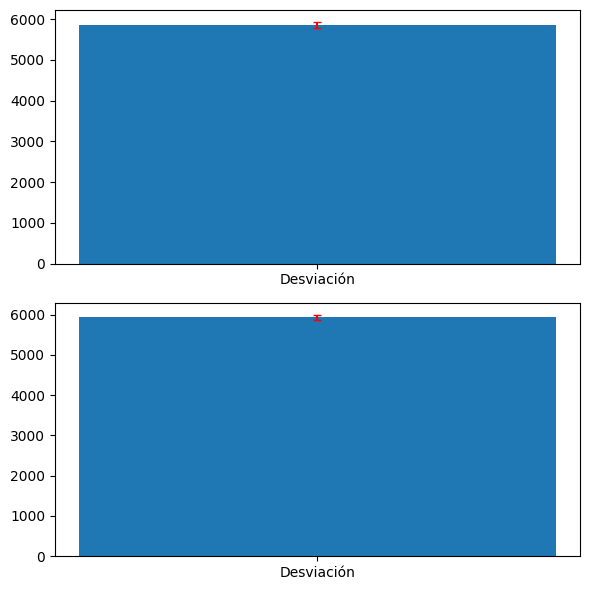

In [69]:
analisis.graficos_intervalos()

In [70]:
analisis.promedio_costos_derivaciones

{'Estrategia 1': 5850.95753509382,
 'Estrategia 2': 5931.838047013987,
 'Estrategia 3': 6012.368115875582}

In [71]:
analisis.intervalo_confianza_tasas_ocupacion

{'Estrategia 1': {'ED': (4.613711649257327, 4.843361521474391),
  'GA': (nan, nan),
  'ICU': (68.79986868557641, 69.35193131442357),
  'OR': (30.789587178761042, 31.45263504346121),
  'SDU_WARD': (89.84834023796135, 89.96537404775289)},
 'Estrategia 2': {'ED': (1.6708039979120795, 1.8540740508684075),
  'GA': (79.01805994921577, 79.67860671745086),
  'ICU': (71.0747384336108, 71.5512615663892),
  'OR': (30.066569125523017, 30.654541985588125),
  'SDU_WARD': (88.45452607935543, 88.57424943084855)},
 'Estrategia 3': {'ED': (1.767534728310451, 1.9424652716895472),
  'GA': (79.06920693343876, 79.7532930665612),
  'ICU': (71.06328345525917, 71.67331654474081),
  'OR': (29.958007235786603, 30.52088165310233),
  'SDU_WARD': (88.49463126397275, 88.63598098092514)}}

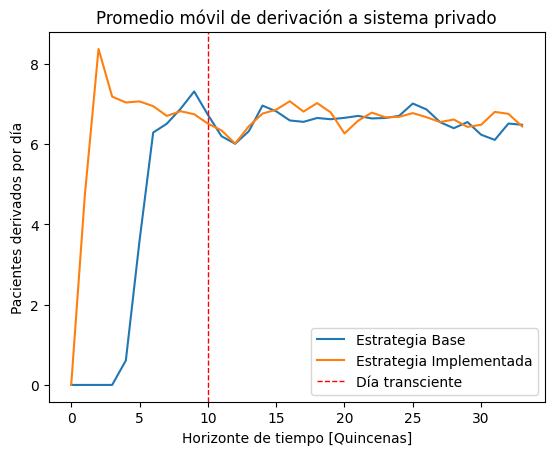

In [93]:
analisis.grafico_lineas_tiempo()

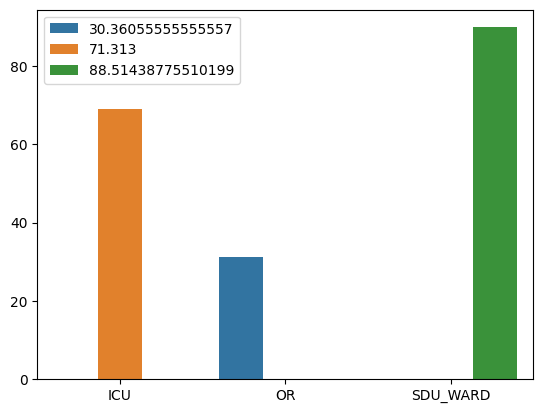

In [24]:
analisis.graficos_intervalos()